# NLP Project: Sequential Sentence Classification

In [1]:
## confirm access to a GPU

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cc0f0ae1-5392-10e9-2457-ea0782d37ad8)


In [2]:
## Getting the data: PubMed 200k Randomized Controlled Trail
## Download from the github
# https://github.com/Franck-Dernoncourt/pubmed-rct


!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 14.96 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [3]:
!ls pubmed-rct

PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [4]:
## Check what files are in the PubMed20k dataset

!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [5]:
## Start our experiments using the 20k dataset number replaced by @ sign

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [6]:
# Check all of the filenames in the target directory

import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt']

In [7]:
os.listdir(data_dir)

['test.txt', 'train.txt', 'dev.txt']

## Visualization:

In [8]:
# create function to read the lines of a document

def get_lines(filename):
  """
  Reads filenama (text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()



In [9]:
# Lets read in the training lines

train_lines = get_lines(data_dir + "/train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
len(train_lines)

210040

Lets think about how we want our data to look like

```
[{"line_number": 0,
   "target": "BACKGROUND:,
   text": "Emotional eating is associated with overeating and the development of obesity .",
   "total_lines": 11 # total lines in an abstract
},
{"line_number": 1,
...continue like this here
}]
```



In [11]:
# function to preprocess text with line numbers

def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence number,
  total number of lines in the abstract, and the actual text of the sentence.
  """

  # get all the lines from the filename
  input_lines = get_lines(filename)
  # create an empty abstract
  abstract_lines=""
  # create an empty list of abstract
  abstract_samples = []

  # loop through each line
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      # reset the abstract_line if the line is abstract_id line
      abstract_lines = ""
    # checking if it is a newline/space
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        if len(target_text_split) == 2:
          line_data["target"] = target_text_split[0]
          line_data["text"] = target_text_split[1].lower()
          line_data["line_number"] = abstract_line_number
          line_data["total_lines"] = len(abstract_line_split) - 1
          abstract_samples.append(line_data)
    else:
      abstract_lines += line
  return abstract_samples


In [12]:
# Get data from file and preprocess it

%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "/train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt")
len(train_samples), len(val_samples), len(test_samples)


CPU times: user 771 ms, sys: 127 ms, total: 898 ms
Wall time: 1.05 s


(180040, 30212, 30135)

In [13]:
# Checking the first abstract of training data

train_samples[:12]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [14]:
import pandas as pd

try_data1 = {
        "name": ["Manoj", "Raju"],
        "age": [22,23]
    }

# or

try2 = [
    {
        "name": "Manoj",
        "age": 22
    },
    {
        "name": "Raju",
        "age": 23
    }
]

dataf1 = pd.DataFrame(try_data1)
dataf2 = pd.DataFrame(try2)

print(dataf1)
print("\n")
print(dataf2)

    name  age
0  Manoj   22
1   Raju   23


    name  age
0  Manoj   22
1   Raju   23


In [15]:
# Visualizing

import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(12)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [16]:
# Distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

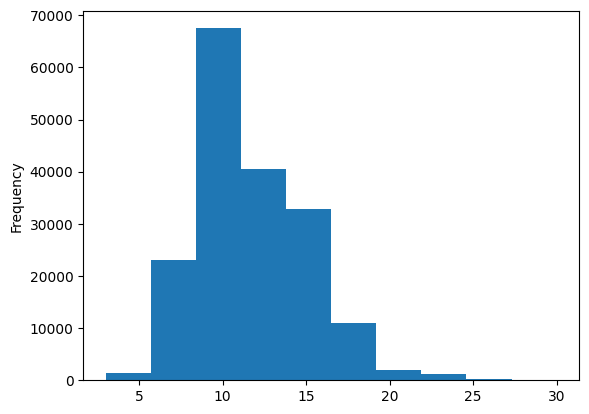

In [17]:
# Lets check the length of different lines

train_df.total_lines.plot.hist();

## Get list of Sentences

In [18]:
# convert abstract text lines into lists

train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [19]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Making Numeric Labels

In [20]:
# One Hot Encode labels

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
train_labels_one_hot.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(180040, 5)

In [21]:
train_labels_one_hot[0]

array([0., 0., 0., 1., 0.])

## Label encoded labels

In [22]:
# Extract labels and encode them into integers

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded[:12]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 1])

In [23]:
# Get class names and numbers of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Model Experiments to Run: 🔨

* Model 0: Naive Bayes with TF-IDF encoder
* Model 1: Conv1D with token embeddings
* Model 2: TensorflowHub Pretrained Feature Extractor
* Model 3: Conv1D with character embedding
* Model 4: Pretrained token embeddings (as 2) + character embeddings (as 3)
* Model 5: Pretrained token embeddings + character embeddings + positional embedding

# MODEL 0: Getting a baseline (NAIVE BAYES)

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(
    X=train_sentences,
    y=train_labels_encoded
)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
# Evaluate
model_0.score(
    X=val_sentences,
    y=val_labels_encoded
)

# we will get accuracy

0.7218323844829869

In [26]:
# Making predictions using out basline model

baseline_preds = model_0.predict(
    val_sentences
)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [27]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [28]:
# Download helper function script

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-07-11 17:45:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-11 17:45:23 (113 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [29]:
from helper_functions import calculate_results

baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for the deep sequence models
- vectorization and embedding hunu paryo

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [31]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [32]:
sent_lens=[len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

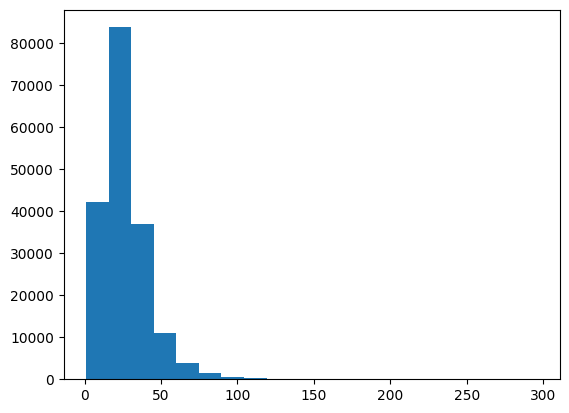

In [33]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [34]:
# How long of a sentence length covers 95% of examples

output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [35]:
max(sent_lens), min(sent_lens)

(296, 1)

## Text Vectorizer layer (Tokenization)
- mapping a token to integer

In [36]:
# How many words are in our vocabulary
max_tokens = 68000
# taken from the paper (for the 20k dataset)

In [37]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(
    max_tokens=max_tokens, # 68k (total vocabulary in dataset)
    output_sequence_length=output_seq_len, # 55 (desired output length of vectorized sequences)
)
# others are left default

In [38]:
text_vectorizer.adapt(train_sentences)

In [39]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
ex significantly increased peak oxygen consumption ( ex , @ ml/kg per minute ; uc , @ ml/kg per minute ; p = @ ) at @ weeks , which persisted during maintenance exercise at @ weeks ( ex , @ ml/kg per minute ; uc , @ ml/kg per minute ; p < @ ) .

Length of text: 57

Vectorized text:
[[3482   39   96  690  617  419 3482 2878  160  929 1761 2878  160  929
    14   15   53  126 2796   52  627  177   15   53 3482 2878  160  929
  1761 2878  160  929   14    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [40]:
# How many words are there in out training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [41]:
# Get the config of our text vectorizer

text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Embedding layer

In [104]:
len(rct_20k_text_vocab)

64841

In [42]:
from tensorflow.keras import layers

embedding = layers.Embedding(
    input_dim=len(rct_20k_text_vocab),
    output_dim=128,
    mask_zero=True, # use masking to handle variable sequence length
    name="token_embedding"
)

In [43]:
# show example embedding
print(f"Sentence before the vectorization:\n{target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"\nBefore embedding after vectorization:\n{vectorized_sentence}")
embedded_sentence = embedding(vectorized_sentence)
print(f"\nAfter embedding:\n{embedded_sentence}")
print(f"\nEmbedded sentence shape:\n {embedded_sentence.shape}")

Sentence before the vectorization:
ex significantly increased peak oxygen consumption ( ex , @ ml/kg per minute ; uc , @ ml/kg per minute ; p = @ ) at @ weeks , which persisted during maintenance exercise at @ weeks ( ex , @ ml/kg per minute ; uc , @ ml/kg per minute ; p < @ ) .

Before embedding after vectorization:
[[3482   39   96  690  617  419 3482 2878  160  929 1761 2878  160  929
    14   15   53  126 2796   52  627  177   15   53 3482 2878  160  929
  1761 2878  160  929   14    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

After embedding:
[[[ 0.01827956 -0.00057505  0.01809379 ... -0.01578599  0.00256233
   -0.03997136]
  [ 0.00221639 -0.04974912 -0.02346394 ... -0.01537541  0.0391182
   -0.02436872]
  [ 0.04683108 -0.04490631 -0.04390055 ...  0.01267029 -0.01548017
    0.01681561]
  ...
  [-0.00390752 -0.0105142   0.04977317 ... -0.01626021 -0.04606218
    0.03802054]
  [-0.00390752 -0.0105142   0.04977317 ..

## Creating dataset
making sure our data loads as fast as possible
 two resources

https://www.tensorflow.org/guide/data_performance

https://www.tensorflow.org/guide/data

In [44]:
# Turn our data into Tensorflow datasets

train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_labels_one_hot)
)
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_sentences, val_labels_one_hot)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_sentences, test_labels_one_hot)
)

In [45]:
type(train_dataset)

tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

In [46]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [47]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [48]:
# Take the TensorSliceDataset and turn them into prefetched dataset

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## MODEL 1: Conv1D Model with Token Embedding

In [49]:
# create conv1d model to process sequences

from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embedding = embedding(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embedding)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x) # 5 classes are there

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [50]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [51]:
len(train_dataset) # no of batches to run

5627

In [52]:
5626*32

180032

In [53]:
model_1_history = model_1.fit(
    train_dataset, # in tf.data type so no need to pass label and text separately this contains both
    steps_per_epoch=int(0.1 * len(train_dataset)), # we only want to train on 10% of steps per epoch (10per of batch)
    epochs=5,
    validation_data=val_dataset,
    validation_steps=int(0.1 * len(val_dataset)) # here also only look for (10% of batch)
)

# so that we can research faster

Epoch 1/5
562/562 [==============================] - 21s 32ms/step - loss: 0.9139 - accuracy: 0.6392 - val_loss: 0.6881 - val_accuracy: 0.7400
Epoch 2/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6631 - accuracy: 0.7539 - val_loss: 0.6395 - val_accuracy: 0.7699
Epoch 3/5
562/562 [==============================] - 4s 7ms/step - loss: 0.6230 - accuracy: 0.7729 - val_loss: 0.5993 - val_accuracy: 0.7839
Epoch 4/5
562/562 [==============================] - 4s 8ms/step - loss: 0.5926 - accuracy: 0.7865 - val_loss: 0.5813 - val_accuracy: 0.7849
Epoch 5/5
562/562 [==============================] - 4s 7ms/step - loss: 0.5940 - accuracy: 0.7912 - val_loss: 0.5658 - val_accuracy: 0.7972


In [54]:
import pandas as pd

model_1_result = pd.DataFrame(model_1_history.history)

In [55]:
model_1_result

,loss,accuracy,val_loss,val_accuracy
0,0.913901,0.639235,0.688121,0.740027
1,0.663135,0.753892,0.639512,0.769947
2,0.622973,0.772854,0.599347,0.783910
3,0.592609,0.786532,0.581313,0.784907
4,0.594035,0.791203,0.565850,0.797207


<Axes: >

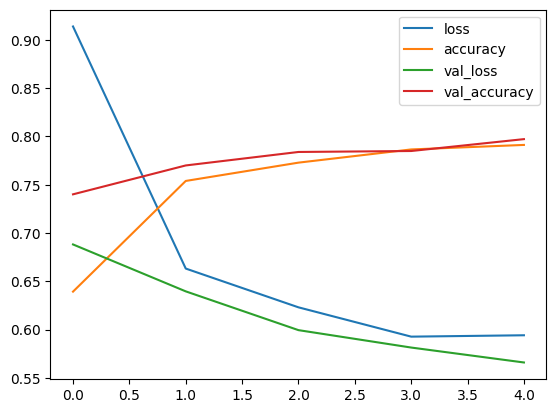

In [56]:
model_1_result.plot()

In [57]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.5650 - accuracy: 0.8011


[0.5650016665458679, 0.8011386394500732]

In [58]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[5.38576841e-01, 1.85807765e-01, 4.55170721e-02, 1.85106277e-01,
        4.49920371e-02],
       [4.57246810e-01, 3.52877438e-01, 2.10007709e-02, 1.37105733e-01,
        3.17692757e-02],
       [1.87884748e-01, 4.47921688e-03, 1.09230960e-03, 8.06490123e-01,
        5.35102372e-05],
       ...,
       [3.44231667e-05, 1.02585624e-03, 3.45096481e-03, 2.52207738e-05,
        9.95463550e-01],
       [9.28440094e-02, 3.33104402e-01, 1.31024614e-01, 8.88988450e-02,
        3.54128152e-01],
       [1.68117747e-01, 7.74015248e-01, 3.45349163e-02, 1.14000244e-02,
        1.19320415e-02]], dtype=float32)

In [59]:
model_1_pred_probs.shape

(30212, 5)

In [60]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [61]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [62]:
model_1_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_1_preds
)
model_1_results

{'accuracy': 80.11386204157289,
 'precision': 0.8031659324187225,
 'recall': 0.8011386204157288,
 'f1': 0.798599083964933}

# MODEL 2: Feature extraction with pretrained token embedding

universal sentence encoder
https://www.kaggle.com/models/google/universal-sentence-encoder

In [63]:
# download pretrained Tensorflow use

import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False, # dont train further in our architecture
    name="universal_sentence_encoder"
)


In [64]:
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"After embedding:\n{use_embedded_sentence[0][:20]}...")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random sentence:
usual gait speed , @-m walk time , chair rise time , and sppb improved for the majority of at participants and usual gait speed , chair rise time , and sppb improved for the majority of rt participants , but there was wide variation in the magnitude of improvement .
After embedding:
[-0.02597817 -0.04398115  0.0065388   0.01672074  0.00046886  0.04780669
  0.06620554 -0.02577027  0.03268364  0.04198645 -0.04432025  0.01765751
  0.00438839  0.05604823  0.0460091   0.05907251  0.0321027  -0.06101246
  0.04274165  0.00964602]...
Length of sentence embedding:
512


In [65]:
# building model 2

inputs = layers.Input(shape=[], dtype=tf.string) # empty list [] visit the sentence encoder doc in tf hub
pretrained_embedding = tf_hub_embedding_layer(inputs)
# tokenize automatically and embedding in 512 dimension
print(pretrained_embedding.shape)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
print(x.shape)
output = layers.Dense(5, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, output)

(None, 512)
(None, 128)


In [66]:
model_2.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [67]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [68]:
model_2_history = model_2.fit(
    train_dataset,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    epochs=5,
    validation_data=val_dataset,
    validation_steps=int(0.1 * len(val_dataset))
)

Epoch 1/5
562/562 [==============================] - 13s 16ms/step - loss: 0.9127 - accuracy: 0.6501 - val_loss: 0.7955 - val_accuracy: 0.6908
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7683 - accuracy: 0.7000 - val_loss: 0.7547 - val_accuracy: 0.7045
Epoch 3/5
562/562 [==============================] - 11s 20ms/step - loss: 0.7520 - accuracy: 0.7116 - val_loss: 0.7399 - val_accuracy: 0.7131
Epoch 4/5
562/562 [==============================] - 12s 22ms/step - loss: 0.7189 - accuracy: 0.7236 - val_loss: 0.7118 - val_accuracy: 0.7274
Epoch 5/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7271 - accuracy: 0.7218 - val_loss: 0.6908 - val_accuracy: 0.7334


In [69]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.6995 - accuracy: 0.7338


[0.6994571685791016, 0.7337812781333923]

In [70]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[6.11064970e-01, 2.31633872e-01, 2.68781278e-03, 1.43179536e-01,
        1.14337495e-02],
       [4.56512988e-01, 4.46226954e-01, 6.70343405e-03, 8.81505832e-02,
        2.40601669e-03],
       [3.62083316e-01, 6.74594119e-02, 3.28944102e-02, 4.82244581e-01,
        5.53181991e-02],
       ...,
       [2.07415759e-03, 2.52851262e-03, 1.19521886e-01, 5.72667050e-04,
        8.75302792e-01],
       [2.76724738e-03, 2.31906679e-02, 5.07945478e-01, 9.86705534e-04,
        4.65109885e-01],
       [1.95640787e-01, 3.90769988e-01, 3.68574232e-01, 2.55835382e-03,
        4.24565822e-02]], dtype=float32)

In [71]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 2, 1])>

In [72]:
model_2_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_2_preds
)
model_2_results

{'accuracy': 73.37812789620018,
 'precision': 0.7303537191566977,
 'recall': 0.7337812789620018,
 'f1': 0.7281090195462401}

# MODEL 3: CONV1D with character embeddings


## Creating a character-level tokenizer

In [73]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [74]:
# function to split sentences into characters

def split_chars(text):
    return " ".join(list(text))

In [76]:
list(train_sentences[0])[:10]

['t', 'o', ' ', 'i', 'n', 'v', 'e', 's', 't', 'i']

In [77]:
split_chars(train_sentences[0])

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [80]:
# Sequences splitting sequence-level data into character-level data splits

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]


In [81]:
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [82]:
len(train_chars), len(val_chars), len(test_chars)

(180040, 30212, 30135)

In [88]:
random_sentence = random.choice(train_sentences)
random_sentence

'although the maximum planned sample size was @ , enrollment was halted early because of loss of equipoise after positive results for thrombectomy were reported from other similar trials .'

In [91]:
len(random_sentence), len(random_sentence.split()) # character length and word length

(187, 30)

In [83]:
chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_lens)
mean_char_len

149.3662574983337

In [86]:
chars_lens[:10]

[281, 137, 111, 65, 209, 147, 161, 164, 180, 51]

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

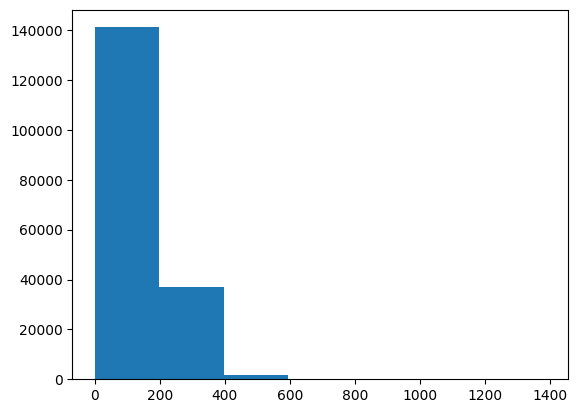

In [87]:
import matplotlib.pyplot as plt
plt.hist(chars_lens, bins=7)

In [92]:
# Find what character length covers 95% of sequences

output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

290

In [94]:
# Get all keyboard characters

import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [99]:
# Create character-level token vectorizer instance

NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV ["UNK"]
char_vectorizer = TextVectorization(
    max_tokens=NUM_CHAR_TOKENS, # all characters length
    output_sequence_length=output_seq_char_len, # 290 (95% of data)
    name="char_vectorizer",
    standardize="lower_and_strip_punctuation", # None for all punctuation so more characters
)

In [100]:
char_vectorizer.adapt(train_chars)

In [101]:
# check character vocab stats

char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [102]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
p r i m a r y   o u t c o m e   m e a s u r e s   i n c l u d e d   t h e   r a t e   o f   p o s i t i v e   b a c t e r i a l   c u l t u r e   f o r   t h e   a b o v e   s a m p l e s   .

Length of random_train_chars: 82

Vectorized chars:
[[14  8  4 15  5  8 19  7 16  3 11  7 15  2 15  2  5  9 16  8  2  9  4  6
  11 12 16 10  2 10  3 13  2  8  5  3  2  7 17 14  7  9  4  3  4 21  2 22
   5 11  3  2  8  4  5 12 11 16 12  3 16  8  2 17  7  8  3 13  2  5 22  7
  21  2  9  5 15 14 12  2  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

# Character level Embedding

In [107]:
from keras import layers

char_embed = layers.Embedding(
    input_dim=len(char_vocab), # number of different characters
    output_dim=25, # according to the med pub paper
    mask_zero=True,
    name="char_embed"
)

In [108]:
print(f"Charified text:\n {random_train_chars}\n\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n")
print(char_embed_example)

Charified text:
 p r i m a r y   o u t c o m e   m e a s u r e s   i n c l u d e d   t h e   r a t e   o f   p o s i t i v e   b a c t e r i a l   c u l t u r e   f o r   t h e   a b o v e   s a m p l e s   .


Embedded chars (after vectorization and embedding):

tf.Tensor(
[[[ 0.00612984  0.04707145 -0.04927358 ... -0.04632069 -0.01175128
    0.04336426]
  [ 0.00113238 -0.01784756 -0.01081656 ...  0.01799742  0.0313595
   -0.03639276]
  [-0.04872608 -0.03648561  0.00568889 ...  0.02520752  0.03355842
    0.00030649]
  ...
  [-0.00604915  0.01290877  0.04938458 ...  0.0224296   0.01261078
   -0.03788413]
  [-0.00604915  0.01290877  0.04938458 ...  0.0224296   0.01261078
   -0.03788413]
  [-0.00604915  0.01290877  0.04938458 ...  0.0224296   0.01261078
   -0.03788413]]], shape=(1, 290, 25), dtype=float32)


## Building Model 3

In [110]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)


In [111]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (None, 64)                4160

In [112]:
model_3.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

## Making data load faster for tensorflow

In [114]:
# create char level dataset

train_char_dataset = tf.data.TextLineDataset.from_tensor_slices(
    (train_chars, train_labels_one_hot)
).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices(
    (val_chars, val_labels_one_hot)
).batch(31).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices(
    (test_chars, test_labels_one_hot)
).batch(32).prefetch(tf.data.AUTOTUNE)

In [115]:
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [116]:
model_3_history = model_3.fit(
    train_char_dataset,
    steps_per_epoch=int(0.1 * len(train_char_dataset)),
    epochs=5,
    validation_data=val_char_dataset,
    validation_steps=int(0.1 * len(val_char_dataset))
)

Epoch 1/5
562/562 [==============================] - 7s 7ms/step - loss: 1.4527 - accuracy: 0.3451 - val_loss: 1.3795 - val_accuracy: 0.4034
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 1.3376 - accuracy: 0.4309 - val_loss: 1.2992 - val_accuracy: 0.4626
Epoch 3/5
562/562 [==============================] - 6s 11ms/step - loss: 1.2955 - accuracy: 0.4622 - val_loss: 1.2775 - val_accuracy: 0.4646
Epoch 4/5
562/562 [==============================] - 3s 6ms/step - loss: 1.2689 - accuracy: 0.4730 - val_loss: 1.2578 - val_accuracy: 0.4845
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 1.2623 - accuracy: 0.4711 - val_loss: 1.2436 - val_accuracy: 0.4915


In [117]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

975/975 [==============================] - 3s 3ms/step


array([[0.24039543, 0.24548815, 0.22133295, 0.20739542, 0.08538804],
       [0.11737923, 0.19044335, 0.19403054, 0.0480254 , 0.4501215 ],
       [0.16167162, 0.15447009, 0.45424566, 0.14858085, 0.08103186],
       ...,
       [0.05426174, 0.11308379, 0.2242231 , 0.03154635, 0.576885  ],
       [0.07275254, 0.13797106, 0.2781964 , 0.06444427, 0.44663578],
       [0.17641728, 0.20188995, 0.16466919, 0.0417986 , 0.415225  ]],
      dtype=float32)

In [118]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 4, 2, ..., 4, 4, 4])>

In [119]:
model_3_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_3_preds
)
model_3_results

{'accuracy': 49.10300542830663,
 'precision': 0.4689777367740181,
 'recall': 0.49103005428306634,
 'f1': 0.4573382325801019}

In [120]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [121]:
model_1_results

{'accuracy': 80.11386204157289,
 'precision': 0.8031659324187225,
 'recall': 0.8011386204157288,
 'f1': 0.798599083964933}

In [123]:
model_2_results

{'accuracy': 73.37812789620018,
 'precision': 0.7303537191566977,
 'recall': 0.7337812789620018,
 'f1': 0.7281090195462401}